# Deep Learning Notebook


This notebook uses MRI Images from the PI-CAI image dataset that contains MRI sequences of patients. It is downloaded from: https://zenodo.org/records/6624726 <br>
Prepared for the dissertation for <b>MSc Software Engineering</b>.<br>
Topic: <b>Enhancing Prostate Cancer Diagnosis through a
Multimodal AI Framework: Integrating Deep
Learning and Ensemble Techniques</b>.
<br><br>
<span style="color:red;">Submitted by: <b>Mihir Sontake (23241713)</b></span>. <br>
<span style="color:red;">Department of Computer Science and Information Systems, University of Limerick.</b></span>

In [ ]:
seed = 42

## Downloading the Images dataset.

Initialise root directory.

In [ ]:
root_directory = "/content/drive/MyDrive/Colab Notebooks/Thesis Prostate Cancer/Dataset"

In [ ]:
import os

os.makedirs(root_directory, exist_ok = True)

Importing Libraries.

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from zipfile import ZipFile
import shutil
!pip install simpleitk
import SimpleITK as sitk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 37.3 MB/s eta 0:00:00


Initialising Image URLs.

In [ ]:
url1 = "https://zenodo.org/records/6624726/files/picai_public_images_fold0.zip"
url2 = "https://zenodo.org/records/6624726/files/picai_public_images_fold1.zip"
url3 = "https://zenodo.org/records/6624726/files/picai_public_images_fold2.zip"
url4 = "https://zenodo.org/records/6624726/files/picai_public_images_fold3.zip"
url5 = "https://zenodo.org/records/6624726/files/picai_public_images_fold4.zip"

Mounting Google Drive Content Folder.

If using google colab notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Downloading Zip folders from URLs to directory.

In [ ]:
os.makedirs(root_directory+"/ZIP Folders", exist_ok = True)

In [ ]:
def download_dataset(url):
    !wget {url} -P root_directory+"/ZIP Folders"

download_dataset(url1)
download_dataset(url2)
download_dataset(url3)
download_dataset(url4)
download_dataset(url5)

--2024-08-01 12:28:32--  https://zenodo.org/records/6624726/files/picai_public_images_fold0.zip
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.103.159, 188.184.98.238, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5368893021 (5.0G) [application/octet-stream]
Saving to: ‘root_directory+/ZIP Folders/picai_public_images_fold0.zip.1’

picai_public_images 100%[===================>]   5.00G  20.6MB/s    in 4m 58s  

2024-08-01 12:33:31 (17.2 MB/s) - ‘root_directory+/ZIP Folders/picai_public_images_fold0.zip.1’ saved [5368893021/5368893021]

--2024-08-01 12:33:31--  https://zenodo.org/records/6624726/files/picai_public_images_fold1.zip
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5164062415 (4.8G) [application/octet-stream]
Sa

Extracting files from ZIP files and saving contents to Patient Folders directory.

In [ ]:
os.makedirs(root_directory+"/Patient Folders", exist_ok = True)

In [ ]:
def extract_dataset_zip(name):
    with ZipFile(name) as zipObj:
      zipObj.extractall(root_directory+"/Patient Folders")

extract_dataset_zip(root_directory+"/ZIP Folders/picai_public_images_fold0.zip")
extract_dataset_zip(root_directory+"/ZIP Folders/picai_public_images_fold1.zip")
extract_dataset_zip(root_directory+"/ZIP Folders/picai_public_images_fold2.zip")
extract_dataset_zip(root_directory+"/ZIP Folders/picai_public_images_fold3.zip")
extract_dataset_zip(root_directory+"/ZIP Folders/picai_public_images_fold4.zip")

## Loading the csv file annotations

In [ ]:
os.makedirs(root_directory+"/Excel", exist_ok = True)

In [ ]:
df = pd.read_csv(root_directory+"/Excel/marksheet.csv")
df.head()

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa
0,10000,1000000,02-07-2019,73,7.7,NaN,55.0,MRBx,0+0,0,0,NO
1,10001,1000001,27-05-2016,64,8.7,0.09,102.0,NaN,NaN,NaN,0,NO
2,10002,1000002,18-04-2021,58,4.2,0.06,74.0,NaN,NaN,NaN,0,NO
3,10003,1000003,05-04-2019,72,13.0,NaN,71.5,SysBx,0+0,0,0,NO
4,10004,1000004,21-10-2020,67,8.0,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO


## Exploratory Data Analysis (EDA)

Data Visualisations.

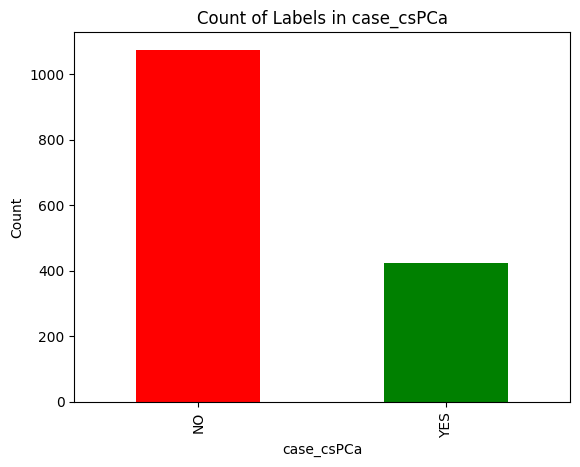

In [ ]:
df['case_csPCa'].value_counts().plot(kind='bar', color=['red', 'green'])
plt.title('Count of Labels in case_csPCa')
plt.xlabel('case_csPCa')
plt.ylabel('Count')
plt.show()

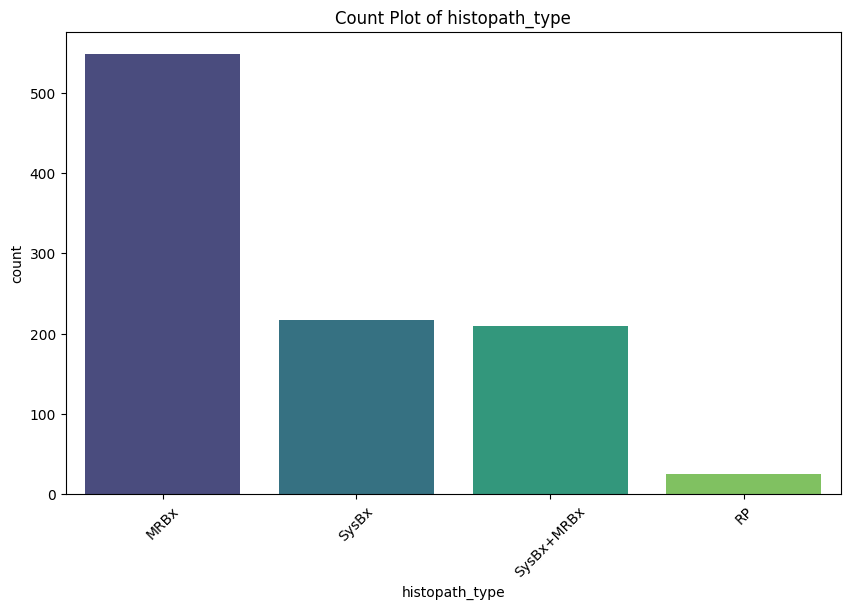

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='histopath_type', data=df, order=df['histopath_type'].value_counts().index, hue = 'histopath_type', palette='viridis', legend = False)
plt.title(f'Count Plot of histopath_type')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.describe()

,patient_id,study_id,patient_age,psa,psad,prostate_volume,case_ISUP
count,1500.000000,1.500000e+03,1500.000000,1460.000000,1049.000000,1473.000000,1500.000000
mean,10735.602667,1.000750e+06,65.595333,11.932397,0.224662,65.045472,0.942000
std,425.311791,4.331570e+02,7.191527,14.939071,0.404288,36.449618,1.333099
min,10000.000000,1.000000e+06,35.000000,0.100000,0.010000,4.000000,0.000000
25%,10368.750000,1.000375e+06,61.000000,5.882500,0.090000,40.000000,0.000000
50%,10733.500000,1.000750e+06,66.000000,8.500000,0.140000,57.000000,0.000000
75%,11101.250000,1.001124e+06,70.000000,13.000000,0.220000,80.000000,2.000000
max,11475.000000,1.001499e+06,92.000000,224.000000,7.000000,308.000000,5.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       1500 non-null   int64  
 1   study_id         1500 non-null   int64  
 2   mri_date         1500 non-null   object 
 3   patient_age      1500 non-null   int64  
 4   psa              1460 non-null   float64
 5   psad             1049 non-null   float64
 6   prostate_volume  1473 non-null   float64
 7   histopath_type   1001 non-null   object 
 8   lesion_GS        1001 non-null   object 
 9   lesion_ISUP      1001 non-null   object 
 10  case_ISUP        1500 non-null   int64  
 11  case_csPCa       1500 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 140.8+ KB


In [ ]:
print(df.isnull().sum())

patient_id           0
study_id             0
mri_date             0
patient_age          0
psa                 40
psad               451
prostate_volume     27
histopath_type     499
lesion_GS          499
lesion_ISUP        499
case_ISUP            0
case_csPCa           0
dtype: int64


In [ ]:
print(df['case_csPCa'].value_counts())

case_csPCa
NO     1075
YES     425
Name: count, dtype: int64


## Divide all Patient images into 'Yes' and 'No' class folders.


In [ ]:
# Create a directory named "input"
# Create sub folders name "Yes" and "No"

import os

# Create a directory named "input"
os.makedirs(root_directory+"/input", exist_ok = True)

# Create sub folders named "Yes" and "No"
os.makedirs(root_directory+"/input/Yes", exist_ok = True)
os.makedirs(root_directory+"/input/No", exist_ok = True)


Divide all .mha images into 'Yes' and 'No' folders according to the label from dataframe.

In [ ]:
import shutil

src_directory = root_directory+"/Patient Folders"
dest_directory = root_directory+"/input"
for idx, row in df.iterrows():
  folder_name = str(row['patient_id'])
  folder_path = os.path.join(src_directory, folder_name)

  if(os.path.exists(folder_path)):
    #all contents of folder_path
    contents = os.listdir(folder_path)
    if(row['case_csPCa'] == 'YES'):
          #copy contents to destdir 'Yes' folder
          for content in contents:
            #if file is .mha
            if content.endswith(".mha"):
              shutil.copy(os.path.join(folder_path, content), os.path.join(dest_directory, 'Yes'))
    else:
      if(row['case_csPCa'] == 'NO'):
          #copy contents to destdir 'No' folder
          for content in contents:
            #if file is .mha
            if content.endswith(".mha"):
              shutil.copy(os.path.join(folder_path, content), os.path.join(dest_directory, 'No'))
  print(f"patient record #{idx} copied to folder.")


patient record #0 copied to folder.
patient record #1 copied to folder.
patient record #2 copied to folder.
patient record #3 copied to folder.
patient record #4 copied to folder.
patient record #5 copied to folder.
patient record #6 copied to folder.
patient record #7 copied to folder.
patient record #8 copied to folder.
patient record #9 copied to folder.
patient record #10 copied to folder.
patient record #11 copied to folder.
patient record #12 copied to folder.
patient record #13 copied to folder.
patient record #14 copied to folder.
patient record #15 copied to folder.
patient record #16 copied to folder.
patient record #17 copied to folder.
patient record #18 copied to folder.
patient record #19 copied to folder.
patient record #20 copied to folder.
patient record #21 copied to folder.
patient record #22 copied to folder.
patient record #23 copied to folder.
patient record #24 copied to folder.
patient record #25 copied to folder.
patient record #26 copied to folder.
patient rec

## Store all slices of .mha images as jpg images into 'Yes' and 'No' class folders.

Extract all slices from .mha image and store in 'Yes' and 'No' folders.

In [ ]:
df_new = df
df_new.head()

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa
0,10000,1000000,02-07-2019,73,7.7,NaN,55.0,MRBx,0+0,0,0,NO
1,10001,1000001,27-05-2016,64,8.7,0.09,102.0,NaN,NaN,NaN,0,NO
2,10002,1000002,18-04-2021,58,4.2,0.06,74.0,NaN,NaN,NaN,0,NO
3,10003,1000003,05-04-2019,72,13.0,NaN,71.5,SysBx,0+0,0,0,NO
4,10004,1000004,21-10-2020,67,8.0,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO


Add number of slices for each record in dataframe.

In [ ]:
mri_sequences = ["t2w", "adc", "cor", "hbv", "sag"]
for sequence in mri_sequences:
    df_new[sequence] = 0

In [ ]:
# Create a directory named "input_slices"
# Create sub folders name "Yes" and "No"

import os

# Create a directory named "input"
os.makedirs(root_directory+"/input_images", exist_ok = True)

# Create sub folders named "Yes" and "No"
os.makedirs(root_directory+"/input_images/Yes", exist_ok = True)
os.makedirs(root_directory+"/input_images/No", exist_ok = True)

In [ ]:
os.makedirs(root_directory+"/input_images/Yes/t2w", exist_ok = True)

os.makedirs(root_directory+"/input_images/Yes/adc", exist_ok = True)

os.makedirs(root_directory+"/input_images/Yes/cor", exist_ok = True)

os.makedirs(root_directory+"/input_images/Yes/hbv", exist_ok = True)

os.makedirs(root_directory+"/input_images/Yes/sag", exist_ok = True)

In [ ]:
os.makedirs(root_directory+"/input_images/No/t2w", exist_ok = True)

os.makedirs(root_directory+"/input_images/No/adc", exist_ok = True)

os.makedirs(root_directory+"/input_images/No/cor", exist_ok = True)

os.makedirs(root_directory+"/input_images/No/hbv", exist_ok = True)

os.makedirs(root_directory+"/input_images/No/sag", exist_ok = True)

In [ ]:
# extract slices from .mha images in input/Yes and save to input_images/Yes

import SimpleITK as sitk

src_dir = root_directory+"/input/Yes"
dest_dir = root_directory+"/input_images/Yes"

for filename in os.listdir(src_dir):
    if filename.endswith(".mha"):
        image_path = os.path.join(src_dir, filename)
        image = sitk.ReadImage(image_path)
        num_slices = image.GetSize()[2]

        # Get the row number of value based on patient_id from filename
        row_num = df_new[df_new['patient_id'] == int(filename[0:5])].index

        # Get the type of mri sequence from filename
        sequence = filename[14:17]

        # Save to dataframe the number of slices for image
        df_new[sequence][row_num] = num_slices

        #commented print(f"image #{image_counter} has {num_slices} slices.")
        dest_dir = root_directory+"/input_images/Yes/" + sequence
        patient_image_counter = 1;
        for slice_num in range(num_slices):
            if(patient_image_counter <= 10):
              slice_image = image[slice_num]
              slice_image = sitk.Cast(slice_image, sitk.sitkUInt8)
              slice_filename = f"{filename[0:5]}_{sequence}_{patient_image_counter}.jpg"
              patient_image_counter += 1
              slice_path = os.path.join(dest_dir, slice_filename)
              sitk.WriteImage(slice_image, slice_path)
            else:
              break

        #commented print(f"Extracted slices from {filename} and saved to {dest_dir}.")
        #commented print(f"Saved {image_counter} 2d image slices.")


Streaming output truncated to the last 5000 lines.
<ipython-input-22-7e3490fafaf4>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[sequence][row_num] = num_slices
<ipython-input-22-7e3490fafaf4>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[sequence][row_num] = num_slices
<ipython-input-22-7e3490fafaf4>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[sequence][row_num] = num_slices
<ipython-input-22-7e3490f

In [ ]:
df_new.head()

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa,t2w,adc,cor,hbv,sag
0,10000,1000000,02-07-2019,73,7.7,NaN,55.0,MRBx,0+0,0,0,NO,0,0,0,0,0
1,10001,1000001,27-05-2016,64,8.7,0.09,102.0,NaN,NaN,NaN,0,NO,0,0,0,0,0
2,10002,1000002,18-04-2021,58,4.2,0.06,74.0,NaN,NaN,NaN,0,NO,0,0,0,0,0
3,10003,1000003,05-04-2019,72,13.0,NaN,71.5,SysBx,0+0,0,0,NO,0,0,0,0,0
4,10004,1000004,21-10-2020,67,8.0,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO,0,0,0,0,0


In [ ]:
# extract slices from .mha images in input/No and save to input_images/No

import SimpleITK as sitk

src_dir = root_directory+"/input/No"
dest_dir = root_directory+"/input_images/No"
for filename in os.listdir(src_dir):
    if filename.endswith(".mha"):
        image_path = os.path.join(src_dir, filename)
        image = sitk.ReadImage(image_path)
        num_slices = image.GetSize()[2]

        # Get the row number of value based on patient_id from filename
        row_num = df_new[df_new['patient_id'] == int(filename[0:5])].index

        # Get the type of mri sequence from filename
        sequence = filename[14:17]

        # Save to dataframe the number of slices for image
        df_new[sequence][row_num] = num_slices

        #commented print(f"image #{image_counter} has {num_slices} slices.")
        dest_dir = root_directory+"/input_images/No/" + sequence
        patient_image_counter = 1
        for slice_num in range(num_slices):
          if(patient_image_counter <= 10):
            slice_image = image[slice_num]
            slice_image = sitk.Cast(slice_image, sitk.sitkUInt8)
            slice_filename = f"{filename[0:5]}_{sequence}_{patient_image_counter}.jpg"
            patient_image_counter += 1
            slice_path = os.path.join(dest_dir, slice_filename)
            sitk.WriteImage(slice_image, slice_path)
          else:
            break

        #commented print(f"Extracted slices from {filename} and saved to {dest_dir}.")
        #commented print(f"Saved {image_counter} 2d image slices.")


Streaming output truncated to the last 5000 lines.
<ipython-input-24-ba4f4aa3a379>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[sequence][row_num] = num_slices
<ipython-input-24-ba4f4aa3a379>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[sequence][row_num] = num_slices
<ipython-input-24-ba4f4aa3a379>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new[sequence][row_num] = num_slices
<ipython-input-24-ba4f4aa

In [ ]:
df_new.head()

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa,t2w,adc,cor,hbv,sag
0,10000,1000000,02-07-2019,73,7.7,NaN,55.0,MRBx,0+0,0,0,NO,31,31,23,31,29
1,10001,1000001,27-05-2016,64,8.7,0.09,102.0,NaN,NaN,NaN,0,NO,21,21,19,21,19
2,10002,1000002,18-04-2021,58,4.2,0.06,74.0,NaN,NaN,NaN,0,NO,22,22,22,22,19
3,10003,1000003,05-04-2019,72,13.0,NaN,71.5,SysBx,0+0,0,0,NO,23,23,23,23,23
4,10004,1000004,21-10-2020,67,8.0,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO,21,21,15,21,19


In [ ]:
## save the dataframe as a csv file

df_new.to_csv(root_directory+'/Excel/dataFrameWithSlices.csv', index=False)

In [ ]:
## verify the dataframe is saved as a csv file

df_verify = pd.read_csv(root_directory+'/Excel/dataFrameWithSlices.csv')
print(df_verify)

      patient_id  study_id    mri_date  patient_age    psa  psad  \
0          10000   1000000  02-07-2019           73   7.70   NaN   
1          10001   1000001  27-05-2016           64   8.70  0.09   
2          10002   1000002  18-04-2021           58   4.20  0.06   
3          10003   1000003  05-04-2019           72  13.00   NaN   
4          10004   1000004  21-10-2020           67   8.00  0.10   
...          ...       ...         ...          ...    ...   ...   
1495       11471   1001495  25-08-2012           71  12.50  0.21   
1496       11472   1001496  28-06-2019           81   5.28  0.12   
1497       11473   1001497  24-09-2017           56  29.60  0.34   
1498       11474   1001498  03-05-2016           71  12.00   NaN   
1499       11475   1001499  23-12-2012           56  15.00  0.46   

      prostate_volume histopath_type    lesion_GS lesion_ISUP  case_ISUP  \
0                55.0           MRBx          0+0           0          0   
1               102.0          

## Exploring the image dataset and visualising images having Cancer and Not having Cancer.

initialise folders and get a list of images contained in the folder.

In [ ]:
input_folder = root_directory+"/input_images/"
yes_folder = root_directory+"/input_images/Yes"
no_folder = root_directory+"/input_images/No"

In [ ]:
import os

yes_t2w_filenames = os.listdir(yes_folder+"/t2w")
yes_t2w_filenames = [os.path.join(yes_folder, "t2w", filename) for filename in yes_t2w_filenames]

yes_adc_filenames = os.listdir(yes_folder+"/adc")
yes_adc_filenames = [os.path.join(yes_folder, "adc", filename) for filename in yes_adc_filenames]

yes_cor_filenames = os.listdir(yes_folder+"/cor")
yes_cor_filenames = [os.path.join(yes_folder, "cor", filename) for filename in yes_cor_filenames]

yes_hbv_filenames = os.listdir(yes_folder+"/hbv")
yes_hbv_filenames = [os.path.join(yes_folder, "hbv", filename) for filename in yes_hbv_filenames]

yes_sag_filenames = os.listdir(yes_folder+"/sag")
yes_sag_filenames = [os.path.join(yes_folder, "sag", filename) for filename in yes_sag_filenames]


In [ ]:
no_t2w_filenames = os.listdir(no_folder+"/t2w")
no_t2w_filenames = [os.path.join(no_folder, "t2w", filename) for filename in no_t2w_filenames]

no_adc_filenames = os.listdir(no_folder+"/adc")
no_adc_filenames = [os.path.join(no_folder, "adc", filename) for filename in no_adc_filenames]

no_cor_filenames = os.listdir(no_folder+"/cor")
no_cor_filenames = [os.path.join(no_folder, "cor", filename) for filename in no_cor_filenames]

no_hbv_filenames = os.listdir(no_folder+"/hbv")
no_hbv_filenames = [os.path.join(no_folder, "hbv", filename) for filename in no_hbv_filenames]

no_sag_filenames = os.listdir(no_folder+"/sag")
no_sag_filenames = [os.path.join(no_folder, "sag", filename) for filename in no_sag_filenames]

In [ ]:
# print the number of images in 'Yes' and 'No'
total_images = 0
yes_images = yes_t2w_filenames + yes_adc_filenames + yes_cor_filenames + yes_hbv_filenames + yes_sag_filenames
no_images = no_t2w_filenames + no_adc_filenames + no_cor_filenames + no_hbv_filenames + no_sag_filenames
print("number of yes_folder images", len(yes_images))
print("number of no_folder images", len(no_images))
total_images = len(yes_images) + len(no_images)
print("number of total images before splitting:", total_images)

number of yes_folder images 21250
number of no_folder images 52800
number of total images before splitting: 74050


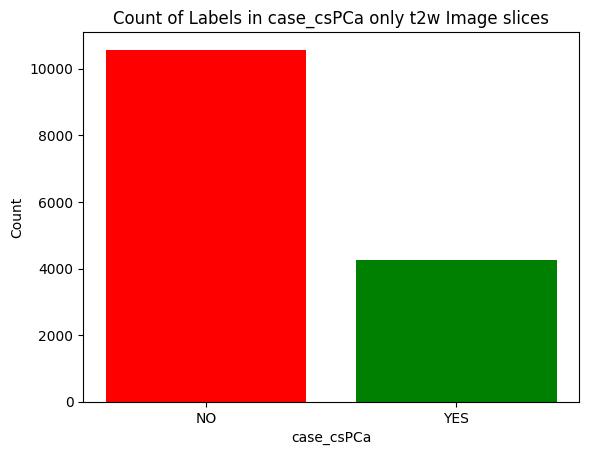

In [ ]:
# Count of Labels in case_csPCa only t2w Image slices
numbers = [len(no_t2w_filenames), len(yes_t2w_filenames)]
labels = ['NO', 'YES']

plt.bar(labels, numbers, color=['red', 'green'])
plt.title('Count of Labels in case_csPCa only t2w Image slices')
plt.xlabel('case_csPCa')
plt.ylabel('Count')
plt.show()

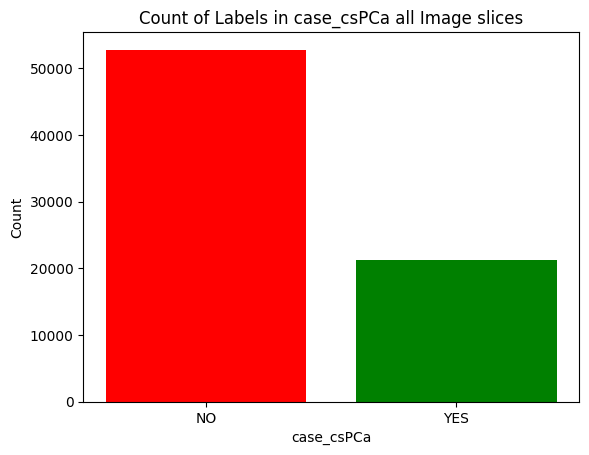

In [ ]:
# Count of Labels in case_csPCa only t2w Image slices
numbers = [len(no_images), len(yes_images)]
labels = ['NO', 'YES']

plt.bar(labels, numbers, color=['red', 'green'])
plt.title('Count of Labels in case_csPCa all Image slices')
plt.xlabel('case_csPCa')
plt.ylabel('Count')
plt.show()

In [ ]:
print("Ratio of Yes images", len(yes_images)/total_images*100)
print("Ratio of No images", len(no_images)/total_images*100)

Ratio of Yes images 28.696826468602293
Ratio of No images 71.3031735313977


Train a model on only t2w images to compare accuracy with a combined images model.

In [ ]:
total_yes = yes_t2w_filenames
total_no = no_t2w_filenames

In [ ]:
total_yes[0:5]

['/content/drive/MyDrive/Colab Notebooks/Thesis Prostate Cancer/Dataset/input_images/Yes/t2w/11143_t2w_1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Thesis Prostate Cancer/Dataset/input_images/Yes/t2w/11143_t2w_2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Thesis Prostate Cancer/Dataset/input_images/Yes/t2w/11143_t2w_3.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Thesis Prostate Cancer/Dataset/input_images/Yes/t2w/11143_t2w_4.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Thesis Prostate Cancer/Dataset/input_images/Yes/t2w/11143_t2w_5.jpg']

In [ ]:
total_no[0:5]

['/content/drive/MyDrive/Colab Notebooks/Thesis Prostate Cancer/Dataset/input_images/No/t2w/11339_t2w_1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Thesis Prostate Cancer/Dataset/input_images/No/t2w/11339_t2w_2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Thesis Prostate Cancer/Dataset/input_images/No/t2w/11339_t2w_3.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Thesis Prostate Cancer/Dataset/input_images/No/t2w/11339_t2w_4.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Thesis Prostate Cancer/Dataset/input_images/No/t2w/11339_t2w_5.jpg']

display positive and negative images from folder belonging to both classes.

In [ ]:
yes_t2w_folder = yes_folder+"/t2w"
no_t2w_folder = no_folder+"/t2w"

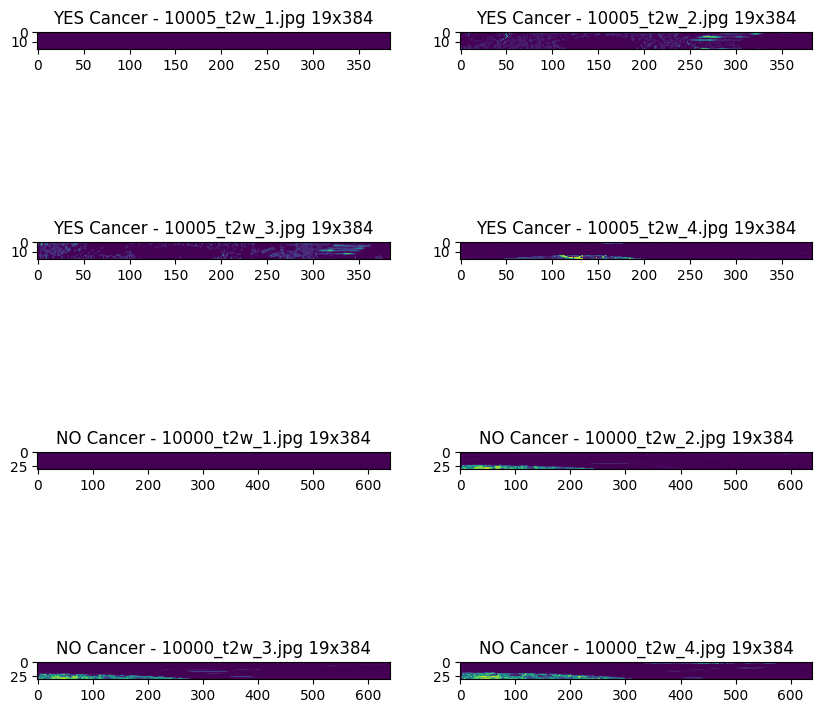

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the images
images_positive = [mpimg.imread(os.path.join(yes_t2w_folder, f)) for f in os.listdir(yes_t2w_folder)[:4]]
images_negative = [mpimg.imread(os.path.join(no_t2w_folder, f)) for f in os.listdir(no_t2w_folder)[:4]]

# Create a figure with 4 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(10, 10))

# Plot the positive images
for idx, ax in enumerate(axes[:2, :].ravel()):
    ax.imshow(images_positive[idx])
    ax.set_title("YES Cancer - " + os.listdir(yes_t2w_folder)[idx] + " " + images_positive[idx].shape[0].__str__() + "x" + images_positive[idx].shape[1].__str__())
# Plot the negative images
for idx, ax in enumerate(axes[2:, :].ravel()):
    ax.imshow(images_negative[idx])
    ax.set_title("NO Cancer - " + os.listdir(no_t2w_folder)[idx] + " " + images_positive[idx].shape[0].__str__() + "x" + images_positive[idx].shape[1].__str__())

# Adjust layout to add space between the positive and negative images
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()

Next we resize the images into a square size to allow for model input in deep learning.

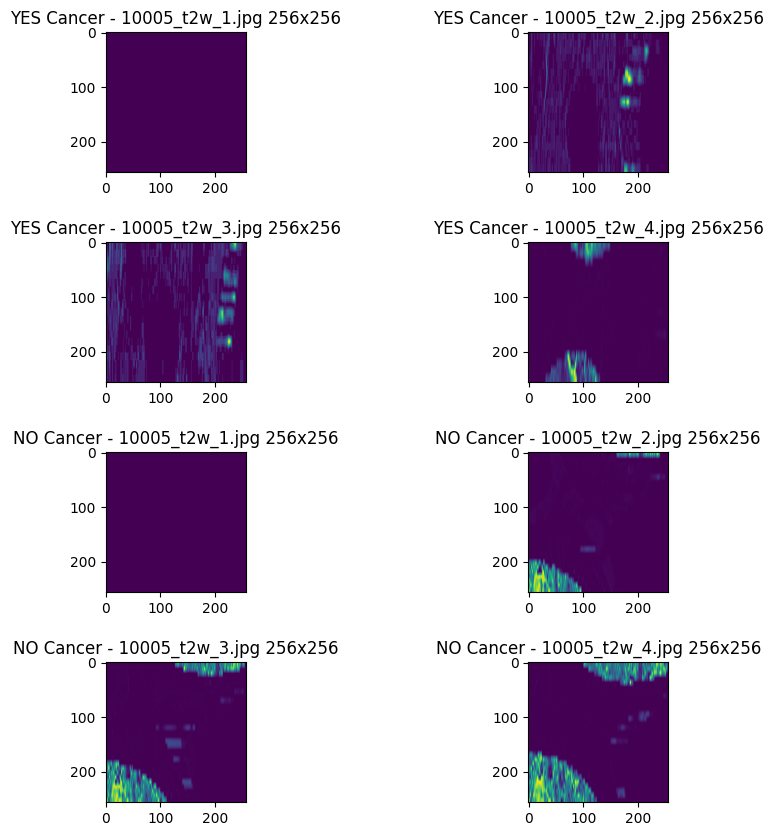

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Resize the images
resized_images_positive = [np.array(Image.fromarray(img).resize((256, 256))) for img in images_positive]
resized_images_negative = [np.array(Image.fromarray(img).resize((256, 256))) for img in images_negative]

# Create a figure with 4 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(10, 10))

# Plot the positive images
for idx, ax in enumerate(axes[:2, :].ravel()):
    ax.imshow(resized_images_positive[idx])
    ax.set_title("YES Cancer - " + os.listdir(yes_t2w_folder)[idx] + " " + resized_images_positive[idx].shape[0].__str__() + "x" + resized_images_positive[idx].shape[1].__str__())

# Plot the negative images
for idx, ax in enumerate(axes[2:, :].ravel()):
    ax.imshow(resized_images_negative[idx])
    ax.set_title("NO Cancer - " + os.listdir(yes_t2w_folder)[idx] + " " + resized_images_negative[idx].shape[0].__str__() + "x" + resized_images_negative[idx].shape[1].__str__())

# Adjust layout to add space between the positive and negative images
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()


Now, comes the part of building the Deep Learning models. I use pre-trained Inception v3 and Resnet 50 models (using Transfer Learning) and compare their accuracies.

## Data Preparation

In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

Choose input images folder.

In [ ]:
yes_folder = root_directory+"/input_images/Yes/"
no_folder = root_directory+"/input_images/No/"

In [ ]:
yes_images = yes_t2w_filenames + yes_adc_filenames + yes_cor_filenames + yes_hbv_filenames + yes_sag_filenames
no_images = no_t2w_filenames + no_adc_filenames + no_cor_filenames + no_hbv_filenames + no_sag_filenames

In [ ]:
# test initially only on t2w images

total_yes = yes_t2w_filenames
total_no = no_t2w_filenames

In [ ]:
# final test on all images together

total_yes = yes_images
total_no = no_images

Append Yes an No images to array.

Optionally, save the data and labels as a .pkl file for faster processing in future.

In [ ]:
import os
import numpy as np
import cv2
from PIL import Image
import concurrent.futures
import matplotlib.image as mpimg

def process_image(imagePath, label, image_size=(256, 256)):
    # load the image, and resize it to be a fixed 256x256 pixels while ignoring aspect ratio
    image = mpimg.imread(imagePath)
    image = Image.fromarray(image).resize(image_size)
    rgb_img = cv2.cvtColor(np.array(image), cv2.COLOR_GRAY2RGB)
    return rgb_img, label

def load_images(image_paths, label, image_size=(256, 256), num_workers=4):
    data = []
    labels = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(process_image, imagePath, label, image_size) for imagePath in image_paths]
        for future in concurrent.futures.as_completed(futures):
            image, lbl = future.result()
            data.append(image)
            labels.append(lbl)

    return np.array(data), np.array(labels)

# Paths to the images
yes_image_paths = total_yes  # List of paths to 'Yes' images
no_image_paths = total_no    # List of paths to 'No' images

print("[INFO] loading 'Yes' images...")
yes_data, yes_labels = load_images(yes_image_paths, label=1)

print("[INFO] loading 'No' images...")
no_data, no_labels = load_images(no_image_paths, label=0)

# Combine the data and labels
data = np.concatenate((yes_data, no_data), axis=0)
labels = np.concatenate((yes_labels, no_labels), axis=0)

print(f"[INFO] Total data shape: {data.shape}")
print(f"[INFO] Total labels shape: {labels.shape}")

saved_map = {
    'data': data,
    'labels': labels
}

import pickle
# Open the file in binary write mode ('wb')
with open(root_directory+'/Variables/alldataandlabels.pkl', 'wb') as f:
  pickle.dump(saved_map, f) # Write the pickled data to the file


[INFO] loading 'Yes' images...
[INFO] loading 'No' images...
[INFO] Total data shape: (74050, 256, 256, 3)
[INFO] Total labels shape: (74050,)


In [ ]:
# Load the pickled variable saved in Drive.
import pickle
with open(root_directory+'/Variables/alldataandlabels.pkl', 'rb') as f: # Use 'rb' for binary read mode
  saved_map = pickle.load(f)

print(len(saved_map['data']))
print(len(saved_map['labels']))

74050
74050


In [ ]:
print(saved_map['labels'][0])

1


Splitting the data into train and test set with 85:15 split.

In [ ]:
# convert the data and labels to NumPy arrays

data = np.array(saved_map['data'][0:40000])
labels = np.array(saved_map['labels'][0:40000])


# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels,
	test_size=0.15, stratify=labels, random_state=42)

Optionally, save the train and test variables in a .pkl file for faster processing in future.

In [ ]:
saved_map = {
    'X_train': X_train,
    'X_test': X_test,
    'Y_train': Y_train,
    'Y_test': Y_test
}

In [ ]:
# Save the python variable 'saved_map' to a Drive file named 'variables.pickle'.
#
# Because it's stored in Drive, this file will persist even if the VM times out.
import pickle
# Open the file in binary write mode ('wb')
with open(root_directory+'/Variables/testandtrain.pkl', 'wb') as f:
  pickle.dump(saved_map, f) # Write the pickled data to the file

In [ ]:
# Load the pickled variable saved in Drive.
import pickle
with open(root_directory+'/Variables/testandtrain.pkl', 'rb') as f: # Use 'rb' for binary read mode
  saved_map3 = pickle.load(f)

In [ ]:
X_train = saved_map3['X_train']
X_test = saved_map3['X_test']
Y_train = saved_map3['Y_train']
Y_test = saved_map3['Y_test']

In [ ]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((34000, 256, 256, 3), (34000,), (6000, 256, 256, 3), (6000,))

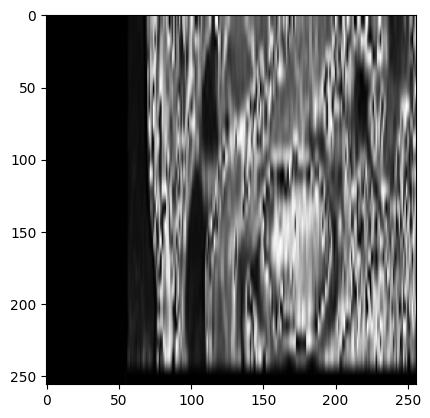

In [ ]:
# visualise the first input

plt.imshow(X_train[20000])

## Building the Models


###  Transfer Learning using Pre-trained Inception v3

In [ ]:
# Pre-trained model 1

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

## pre trained inception v3 model
## using imagenet wights
## not using 1st and last layer of inception

inception = InceptionV3(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
## don't train existing weights

for layer in inception.layers:
  layer.trainable = False

#### Inception 1

In [ ]:
# Import the standard Adam optimizer from Keras
from tensorflow.keras.optimizers import Adam

# Create an Adam optimizer instance
opt_1 = Adam(learning_rate=0.0001)

In [ ]:
## plain inception v3 with modified input and output

## flatten the layers from inception output
x = layers.Flatten()(inception.output)
prediction = layers.Dense(1, activation='sigmoid')(x)
model_1 = Model(inputs = inception.input, outputs = prediction)
model_1.compile(loss='binary_crossentropy', optimizer=opt_1, metrics=['accuracy'])

In [ ]:
os.makedirs(root_directory+"/Models", exist_ok = True)

In [ ]:
# saving and loading the .h5 model
from tensorflow.keras.models import load_model

# save model
model_1.save(root_directory+"/Models/inception_v3_experiment2.h5")
print('Model Saved!')

# load model
model_1=load_model(root_directory+"/Models/inception_v3_experiment2.h5")
model_1.summary()

#### Inception 2

In [ ]:
## added layers on top of inception v3 with dropout and L2 regularization for overfitting scenario
# Import the standard Adam optimizer from Keras
from tensorflow.keras.optimizers import Adam

# Create an Adam optimizer instance
opt_2 = Adam(learning_rate=0.0001)

from tensorflow.keras.regularizers import L2

x = layers.Flatten()(inception.output)

x = layers.Dense(1024, activation='relu', kernel_regularizer=L2(0.001))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=L2(0.001))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=L2(0.001))(x)
x = layers.Dropout(0.2)(x)
prediction = layers.Dense(1, activation='sigmoid')(x)

model_2 = Model(inputs = inception.input, outputs = prediction)
model_2.compile(loss='binary_crossentropy', optimizer=opt_2, metrics=['accuracy'])

In [ ]:
# saving and loading the .h5 model
from tensorflow.keras.models import load_model

# save model
model_2.save(root_directory+"/Models/inception_v3_modified_experiment2.h5")
print('Model Saved!')

# load model
model_2=load_model(root_directory+"/Models/inception_v3_modified_experiment2.h5")
model_2.summary()

### Transfer Learning using Pre-trained Resnet 50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import Model
# Import the standard Adam optimizer from Keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
# Create an Adam optimizer instance
opt_3 = Adam(learning_rate=0.0001)
# Define the image dimensions
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

# Load the pre-trained ResNet50 model with ImageNet weights
resnet50_model = ResNet50(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), weights='imagenet', include_top=False)

# Freeze the pre-trained layers
for layer in resnet50_model.layers:
    layer.trainable = False

#### ResNet 1

In [ ]:
# model 1 resnet
# Add a new classification layer
x = layers.Flatten()(resnet50_model.output)
prediction = layers.Dense(1, activation='sigmoid')(x)

# Create the model
model_resnet1 = Model(inputs=resnet50_model.input, outputs=prediction)

# Compile the model
model_resnet1.compile(loss='binary_crossentropy', optimizer=opt_3, metrics=['accuracy'])

In [ ]:
# save model
from tensorflow.keras.models import load_model
model_resnet1.save(root_directory+"/Models/resnet50_model_1_experiment2.h5")
print('Model Saved!')

# load model
model_resnet1=load_model(root_directory+"/Models/resnet50_model_1_experiment2.h5")
model_resnet1.summary()

#### ResNet 2

In [ ]:
# model 2 resnet
# Import the standard Adam optimizer from Keras
from tensorflow.keras.optimizers import Adam

# Create an Adam optimizer instance
opt_4 = Adam(learning_rate=0.0001)

from tensorflow.keras.regularizers import L2
x = layers.Flatten()(resnet50_model.output)

x = layers.Dense(1024, activation='relu', kernel_regularizer=L2(0.001))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=L2(0.001))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=L2(0.001))(x)
x = layers.Dropout(0.2)(x)
prediction = layers.Dense(1, activation='sigmoid')(x)

model_resnet2 = Model(inputs = resnet50_model.input, outputs = prediction)
model_resnet2.compile(loss='binary_crossentropy', optimizer=opt_4, metrics=['accuracy'])

In [ ]:
# save model
model_resnet2.save(root_directory+"/Models/resnet50_model_2_experiment2.h5")
print('Model Saved!')

# load model
model_resnet2=load_model(root_directory+"/Models/resnet50_model_2_experiment2.h5")
model_resnet2.summary()

## Training the Models.

Image data generators for train and validation/test.

Training data will have augmentation. Test data will not be augmented.

Rescaled the pixel values by dividing them by 255.

### Inception 1

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.02,
                                   height_shift_range=0.02,
                                   shear_range=0.02,
                                   zoom_range=0.02,
                                   horizontal_flip=False)

# the test data is not to be augmented
val_datagen = ImageDataGenerator(rescale=1./255)

Early Stopping to stop the training process when condition is satisfied.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(patience=4,
                              min_delta=0.001,
                              monitor="val_accuracy",
                              restore_best_weights=True,
                              mode="max",
                              verbose=1)

Selecting batch size and number of epochs for model training.

In [ ]:
# model training
# batch size = 32
# epochs = 10
batch_size = 32
epochs = 15
steps_per_epoch = int(len(X_train)/batch_size) # Convert steps_per_epoch to integer
validation_steps = int(len(X_test)/batch_size)  # Convert validation_steps to integer


print("[INFO] training model...")
H1 = model_1.fit(
	x=train_datagen.flow(X_train, Y_train, batch_size=32),
	steps_per_epoch=steps_per_epoch,
	validation_data=val_datagen.flow(X_test, Y_test),
	validation_steps=validation_steps,
	callbacks=[],
	epochs=epochs)

[INFO] training model...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 533s 483ms/step - accuracy: 0.7115 - loss: 0.5557 - val_accuracy: 0.7116 - val_loss: 0.5037
Epoch 2/15
   1/1062 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.8750 - loss: 0.3620

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8750 - loss: 0.3620 - val_accuracy: 0.8125 - val_loss: 0.4721
Epoch 3/15
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 508s 475ms/step - accuracy: 0.7648 - loss: 0.4615 - val_accuracy: 0.7746 - val_loss: 0.4624
Epoch 4/15
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 30us/step - accuracy: 0.8750 - loss: 0.3457 - val_accuracy: 0.7500 - val_loss: 0.5179
Epoch 5/15
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 508s 475ms/step - accuracy: 0.7798 - loss: 0.4318 - val_accuracy: 0.7246 - val_loss: 0.4843
Epoch 6/15
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 33us/step - accuracy: 0.6562 - loss: 0.4788 - val_accuracy: 0.6250 - val_loss: 0.6142
Epoch 7/15
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 508s 475ms/step - accuracy: 0.7855 - loss: 0.4220 - val_accuracy: 0.7853 - val_loss: 0.4380
Epoch 8/15
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 29us/step - accuracy: 0.6875 - loss: 0.5014 - val_accuracy: 0.6250 - val_loss: 0.7688
Epoch 9/15
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 509s 476ms/step - accuracy: 0.8007 - loss: 0

### Inception 2

In [ ]:
# model training
# batch size = 32
# epochs = 20
batch_size = 32
epochs = 20
steps_per_epoch = int(len(X_train)/batch_size) # Convert steps_per_epoch to integer
validation_steps = int(len(X_test)/batch_size)  # Convert validation_steps to integer

print("[INFO] training model...")
H2 = model_2.fit(
	x=train_datagen.flow(X_train, Y_train, batch_size=32),
	steps_per_epoch=steps_per_epoch,
	validation_data=val_datagen.flow(X_test, Y_test),
	validation_steps=validation_steps,
	callbacks=[early_stopping],
	epochs=epochs)

[INFO] training model...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 447s 401ms/step - accuracy: 0.6761 - loss: 2.9739 - val_accuracy: 0.7664 - val_loss: 1.5279
Epoch 2/20
   1/1062 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.8750 - loss: 1.4285

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8750 - loss: 1.4285 - val_accuracy: 0.7500 - val_loss: 1.5149
Epoch 3/20
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 409s 383ms/step - accuracy: 0.7514 - loss: 1.3960 - val_accuracy: 0.7761 - val_loss: 1.0671
Epoch 4/20
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.7812 - loss: 0.9774 - val_accuracy: 0.8125 - val_loss: 0.9960
Epoch 5/20
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 408s 382ms/step - accuracy: 0.7594 - loss: 1.0234 - val_accuracy: 0.7747 - val_loss: 0.8593
Epoch 6/20
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - accuracy: 0.9375 - loss: 0.7067 - val_accuracy: 0.8750 - val_loss: 0.7858
Epoch 7/20
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 408s 382ms/step - accuracy: 0.7717 - loss: 0.8248 - val_accuracy: 0.7797 - val_loss: 0.7292
Epoch 8/20
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 32us/step - accuracy: 0.7500 - loss: 0.7755 - val_accuracy: 0.6875 - val_loss: 0.7262
Epoch 9/20
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 408s 381ms/step - accuracy: 0.7804 - loss:

### ResNet 1

In [ ]:
## fit the resnet model

# batch size = 32
# epochs = 10
batch_size = 32
epochs = 15
steps_per_epoch = int(len(X_train)/batch_size) # Convert steps_per_epoch to integer
validation_steps = int(len(X_test)/batch_size)  # Convert validation_steps to integer
print("[INFO] training model...")
H3 = model_resnet1.fit(
  x=train_datagen.flow(X_train, Y_train, batch_size=32),
	steps_per_epoch=steps_per_epoch,
	validation_data=val_datagen.flow(X_test, Y_test),
	validation_steps=validation_steps,
	callbacks=[early_stopping],
	epochs=epochs)

[INFO] training model...
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 429s 390ms/step - accuracy: 0.6336 - loss: 0.6537 - val_accuracy: 0.7054 - val_loss: 0.5795
Epoch 2/15
   1/1062 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.6250 - loss: 0.6448

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6250 - loss: 0.6448 - val_accuracy: 0.8750 - val_loss: 0.4557
Epoch 3/15
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 409s 383ms/step - accuracy: 0.7027 - loss: 0.5895 - val_accuracy: 0.7390 - val_loss: 0.5700
Epoch 4/15
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 30us/step - accuracy: 0.8125 - loss: 0.4076 - val_accuracy: 0.6875 - val_loss: 0.6373
Epoch 5/15
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 410s 383ms/step - accuracy: 0.7132 - loss: 0.5746 - val_accuracy: 0.6765 - val_loss: 0.5798
Epoch 6/15
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 31us/step - accuracy: 0.6562 - loss: 0.7154 - val_accuracy: 0.5625 - val_loss: 0.6098
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 2.


### ResNet 2

In [ ]:
## fit the resnet model 2

# batch size = 32
# epochs = 10
batch_size = 32
epochs = 20
steps_per_epoch = int(len(X_train)/batch_size) # Convert steps_per_epoch to integer
validation_steps = int(len(X_test)/batch_size)  # Convert validation_steps to integer
print("[INFO] training model...")
H4 = model_resnet2.fit(
  x=train_datagen.flow(X_train, Y_train, batch_size=32),
	steps_per_epoch=steps_per_epoch,
	validation_data=val_datagen.flow(X_test, Y_test),
	validation_steps=validation_steps,
	callbacks=[early_stopping],
	epochs=epochs)

[INFO] training model...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 458s 417ms/step - accuracy: 0.5820 - loss: 1.9526 - val_accuracy: 0.6467 - val_loss: 1.2380
Epoch 2/20
   1/1062 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.6250 - loss: 1.2008

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1062/1062 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6250 - loss: 1.2008 - val_accuracy: 0.7500 - val_loss: 1.2581
Epoch 3/20
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 433s 405ms/step - accuracy: 0.6134 - loss: 1.1927 - val_accuracy: 0.7081 - val_loss: 1.0024
Epoch 4/20
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 32us/step - accuracy: 0.7188 - loss: 0.9913 - val_accuracy: 0.7500 - val_loss: 0.9540
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


## Evaluating the 4 Models and comparing their results.

Plot the training accuracy and loss, and test accuracy and loss.

### Inception 1

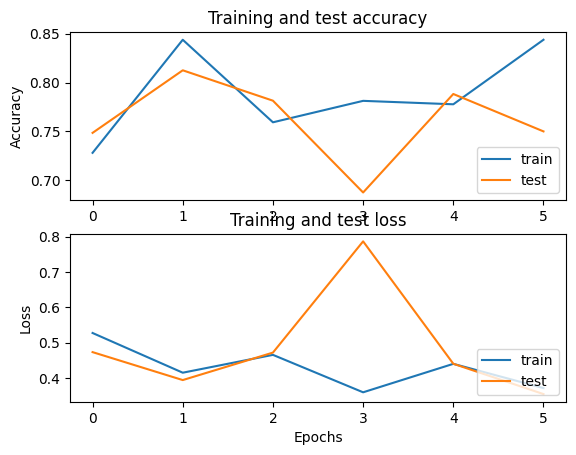

In [ ]:
import matplotlib.pyplot as plt

# Get the accuracy and test accuracy from history object
acc = H1.history['accuracy']
val_acc = H1.history['val_accuracy']

# Get the loss and test loss from history object
loss = H1.history['loss']
val_loss = H1.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.show()

In [ ]:
print(f'Final Accuracy = {H1.history["val_accuracy"][-1]}')
print(f'Final Loss = {H1.history["val_loss"][-1]}')

Final Accuracy = 0.75
Final Loss = 0.3546287715435028


### Inception 2

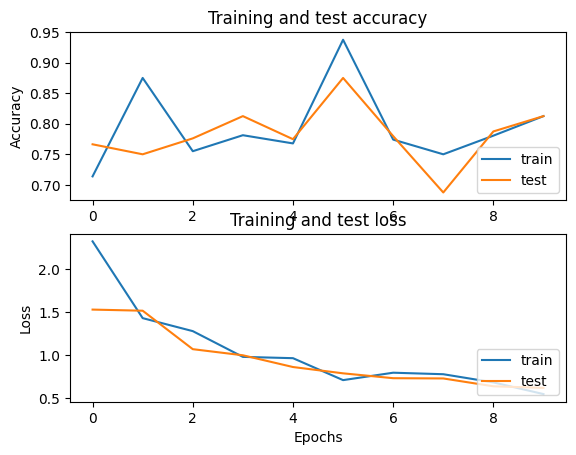

In [ ]:
import matplotlib.pyplot as plt

# Get the accuracy and test accuracy from history object
acc = H2.history['accuracy']
val_acc = H2.history['val_accuracy']

# Get the loss and test loss from history object
loss = H2.history['loss']
val_loss = H2.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.show()

In [ ]:
print(f'Final Accuracy = {H2.history["val_accuracy"][-1]}')
print(f'Final Loss = {H2.history["val_loss"][-1]}')

Final Accuracy = 0.7333333492279053
Final Loss = 0.7149426341056824


### ResNet 1

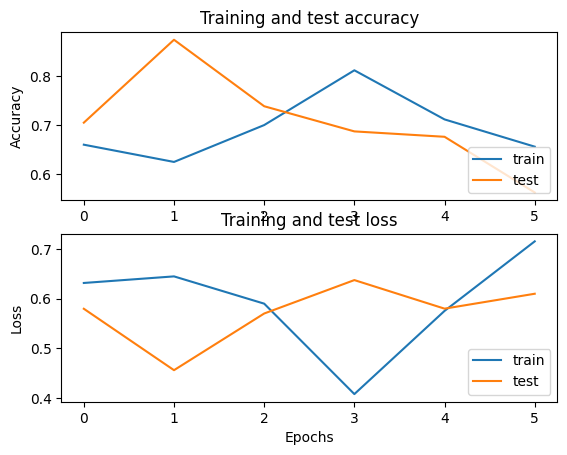

In [ ]:
import matplotlib.pyplot as plt

# Get the accuracy and test accuracy from history object
acc = H3.history['accuracy']
val_acc = H3.history['val_accuracy']

# Get the loss and test loss from history object
loss = H3.history['loss']
val_loss = H3.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.show()

In [ ]:
print(f'Final Accuracy = {H3.history["val_accuracy"][-1]}')
print(f'Final Loss = {H3.history["val_loss"][-1]}')

Final Accuracy = 0.5625
Final Loss = 0.6098014116287231


### ResNet 2

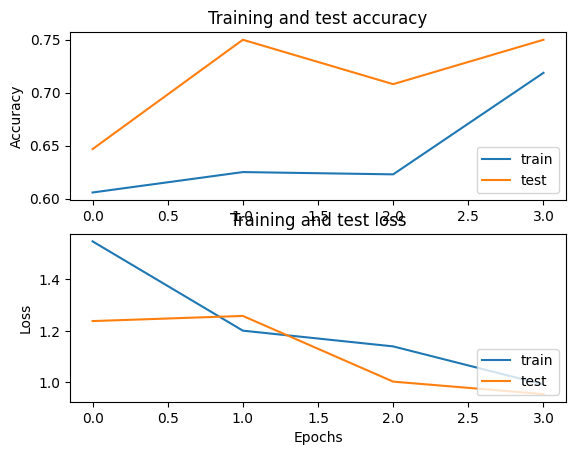

In [ ]:
import matplotlib.pyplot as plt

# Get the accuracy and test accuracy from history object
acc = H4.history['accuracy']
val_acc = H4.history['val_accuracy']

# Get the loss and test loss from history object
loss = H4.history['loss']
val_loss = H4.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

plt.subplot(2,1,1)
plt.plot(epochs, acc, label="train")
plt.plot(epochs, val_acc, label="test")
plt.ylabel("Accuracy")
plt.title('Training and test accuracy')
plt.legend(loc="lower right")

plt.subplot(2,1,2)
plt.plot(epochs, loss, label="train")
plt.plot(epochs, val_loss, label="test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and test loss')
plt.legend(loc="lower right")

plt.show()

In [ ]:
print(f'Final Accuracy = {H4.history["val_accuracy"][-1]}')
print(f'Final Loss = {H4.history["val_loss"][-1]}')

Final Accuracy = 0.7333333492279053
Final Loss = 1.092348337173462
